In [1]:
#!pip install tensorflow==2.13.0

In [2]:
import numpy as np
import tensorflow as tf
print('NP:', np.__version__)
print('TF:', tf.__version__)

NP: 1.25.2
TF: 2.15.0


In [3]:
# importo le librerie
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# SET DEL SEED PER OTTENERE GLI STESSI RISULTATI
SEED = 42
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)
np.random.seed(SEED)

In [28]:
def load_dataset():
  # carico i dati in formato CSV
  CO2 = pd.read_csv("/content/2024-06-26_CO2_influxdb_data.csv", header=3)
  Noise = pd.read_csv("/content/2024-06-26_noise_influxdb_data.csv", header=3)

  return CO2, Noise

In [29]:
# Carica i dati dal dataset
CO2, Noise = load_dataset()

# DIRECTED PROBLEM
X = np.array(CO2[['_value']])
y = np.array(Noise['_value'])

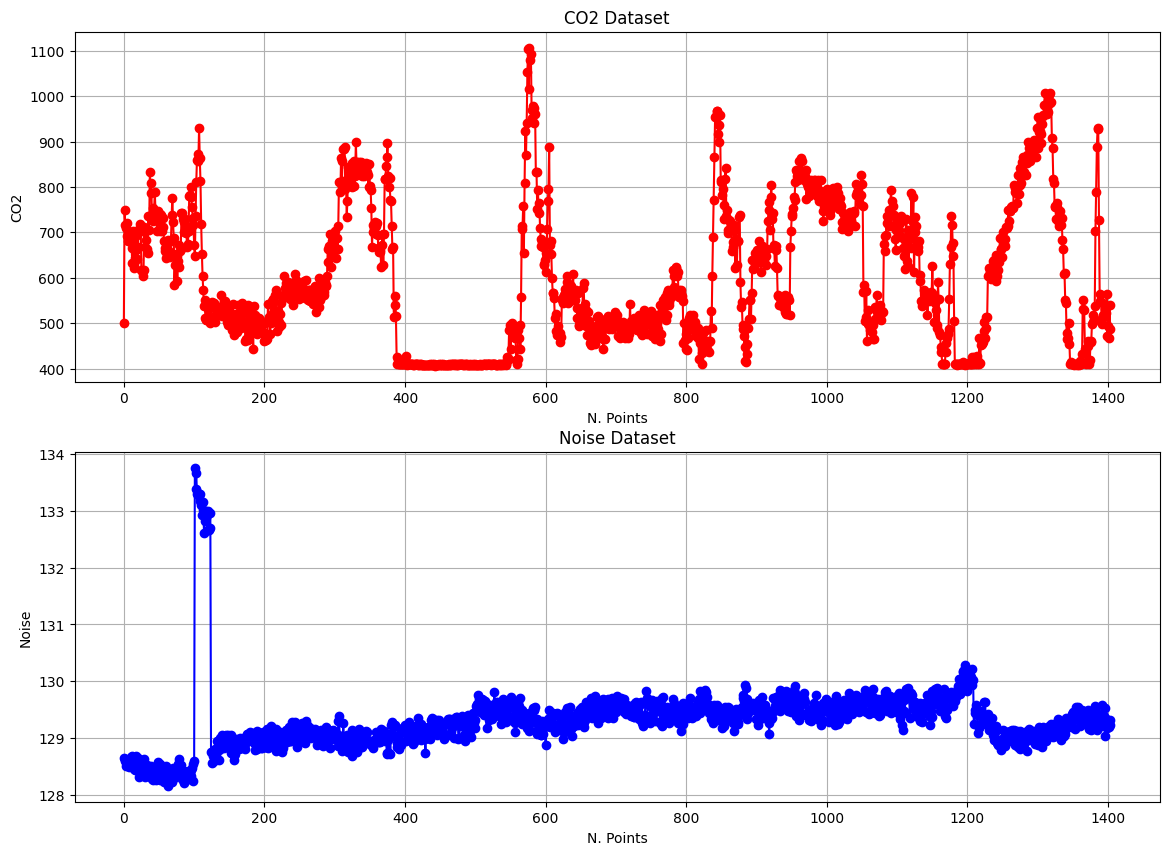

In [30]:
# Plot dataset
plt.figure(figsize=(14,10))

plt.subplot(2, 1, 1)
plt.title('CO2 Dataset')
plt.plot(X, 'ro-')
plt.xlabel('N. Points')
plt.ylabel('CO2')
plt.grid()

plt.subplot(2, 1, 2)
plt.title('Noise Dataset')
plt.plot(y, 'bo-')
plt.xlabel('N. Points')
plt.ylabel('Noise')
plt.grid()

plt.savefig('/content/dataset_1.png')
plt.show()

In [31]:
# Creiamo sequenze di dati per LSTM
def create_sequences(X, y, seq_length=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 40  # Lunghezza delle sequenze
X_seq, y_seq = create_sequences(X, y, seq_length)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 40, 64)            256       
                                                                 
 conv1d_11 (Conv1D)          (None, 40, 32)            4128      
                                                                 
 conv1d_12 (Conv1D)          (None, 40, 32)            2080      
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 30)                38430     
                                                                 
 dense_9 (Dense)             (None, 1)                 31        
                                                                 
Total params: 44925 (175.49 KB)
Trainable params: 4492

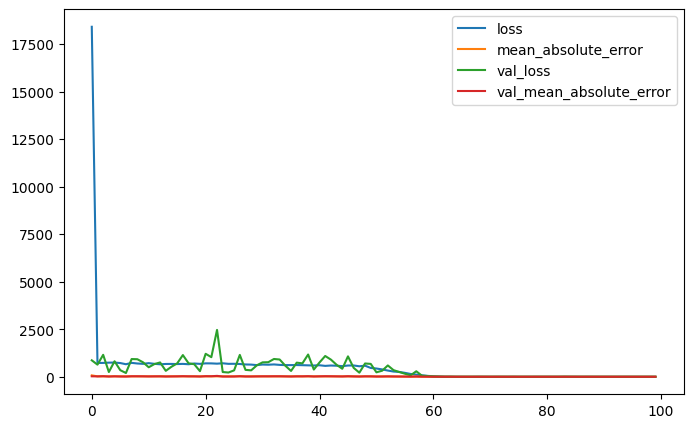

In [32]:
# NON SEPARARE IL DATASET RANDOMICAMENTE (SERIE TEMPORALI)
N = len(X_seq)

train_samples = int(0.6*N)
valid_samples = int(0.2*N)
test_samples = N - (train_samples + valid_samples)

# split and reshape input and label data
X_train, y_train = X_seq[: train_samples], y_seq[: train_samples]
X_val, y_val = X_seq[train_samples : -test_samples], y_seq[train_samples : -test_samples]
X_test, y_test = X_seq[-test_samples :], y_seq[-test_samples :]

# Aggiusto la forma dei dati per l'input della LSTM
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# save test data for inference on raspberry pi 3
with open('X_test_1.npy', 'wb') as f1:
    np.save(f1, X_test)

with open('y_test_1.npy', 'wb') as f2:
    np.save(f2, y_test)

# Crea il modello
model_1 = Sequential()
model_1.add(Input(shape=(seq_length, 1), name='input')),
model_1.add(Conv1D(filters=64, kernel_size=3, activation='linear', padding='same'))
model_1.add(Conv1D(filters=32, kernel_size=2, activation='linear', padding='same'))
model_1.add(Conv1D(filters=32, kernel_size=2, activation='linear', padding='same'))
model_1.add(Flatten())
model_1.add(Dense(30, activation='linear'))
model_1.add(Dense(1, activation='linear'))

# Compila il modello
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics='mean_absolute_error')

# Summary del modello
model_1.summary()

# Addestra il modello
history = model_1.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=10)

# History plot
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(8, 5))
plt.show()

In [33]:
# Valuta il modello
loss = model_1.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss[0]}')
print(f'Mean Absolute Error on Test Data: {loss[1]}')

# Fai delle previsioni
y_pred = model_1.predict(X_test)

9/9 [==============================] - 0s 3ms/step - loss: 0.2940 - mean_absolute_error: 0.4319
Mean Squared Error on Test Data: 0.2940309941768646
Mean Absolute Error on Test Data: 0.4319344460964203
9/9 [==============================] - 0s 3ms/step


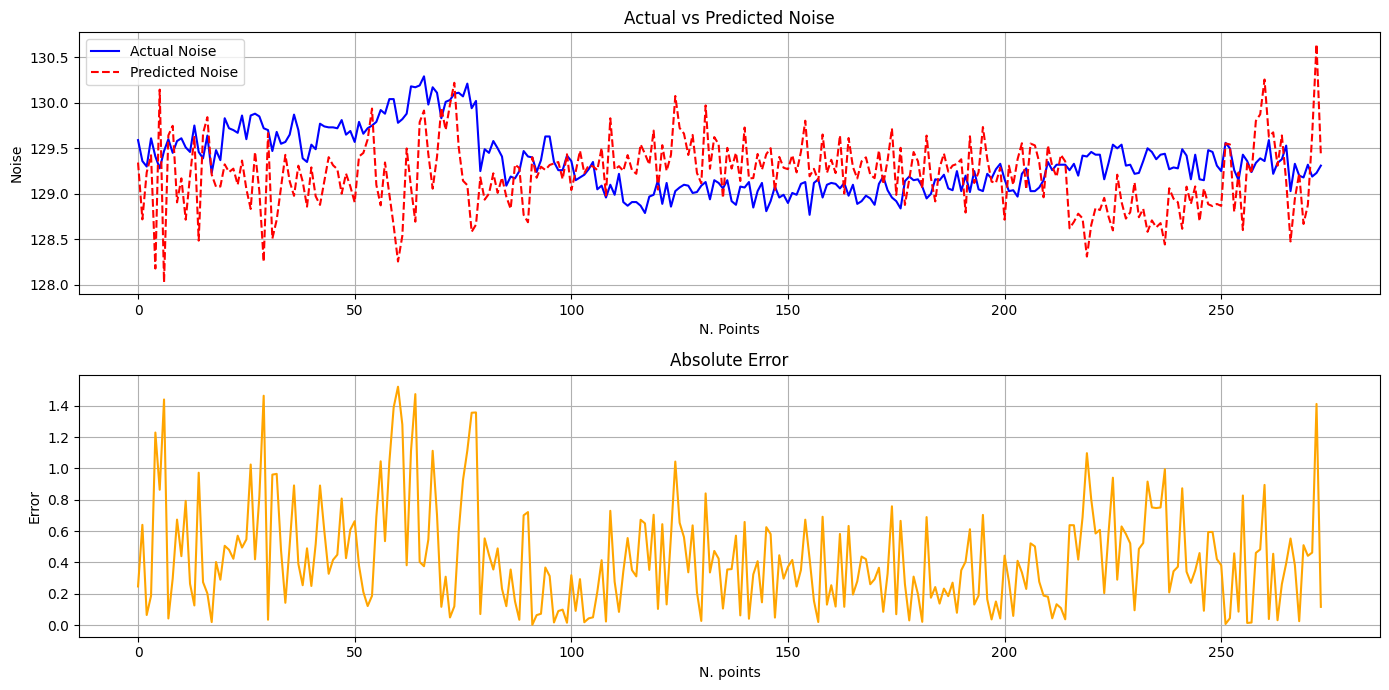

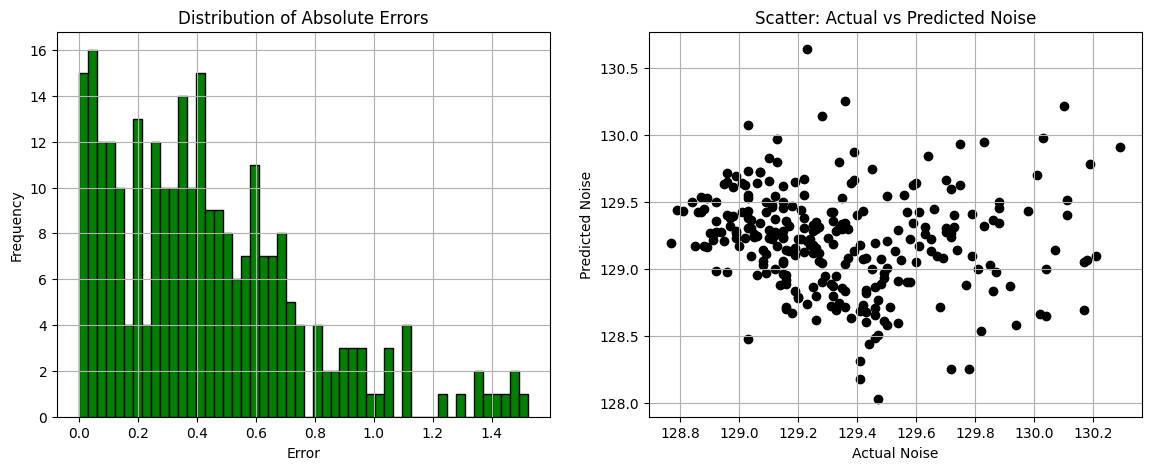

In [34]:
# Visualizza i risultati
plt.figure(figsize=(14, 7))

# Plot a linea
plt.subplot(2, 1, 1)
plt.plot(y_test, color='blue', label='Actual Noise')
plt.plot(y_pred, color='red', label='Predicted Noise', linestyle='--')
plt.title('Actual vs Predicted Noise')
plt.xlabel('N. Points')
plt.ylabel('Noise')
plt.legend()
plt.grid()

# Plot dell'errore assoluto
plt.subplot(2, 1, 2)
absolute_error = np.abs(y_test - y_pred.flatten())
plt.plot(absolute_error, color='orange')
plt.title('Absolute Error')
plt.xlabel('N. points')
plt.ylabel('Error')
plt.grid()

plt.tight_layout()
plt.savefig('/content/results_1.png')
plt.show()

plt.figure(figsize=(14, 5))

# Plot della distribuzione degli errori
plt.subplot(1, 2, 1)
plt.hist(absolute_error, bins=50, color='green', edgecolor='black')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

# Visualizza i risultati in uno scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='black')
plt.title('Scatter: Actual vs Predicted Noise')
plt.xlabel('Actual Noise')
plt.ylabel('Predicted Noise')
plt.grid()

plt.savefig('/content/distribution_1.png')
plt.show()

In [35]:
# ---------------------------------------------------------------------

# INVERTED PROBLEM
X = np.array(Noise[['_value']])
y = np.array(CO2['_value'])

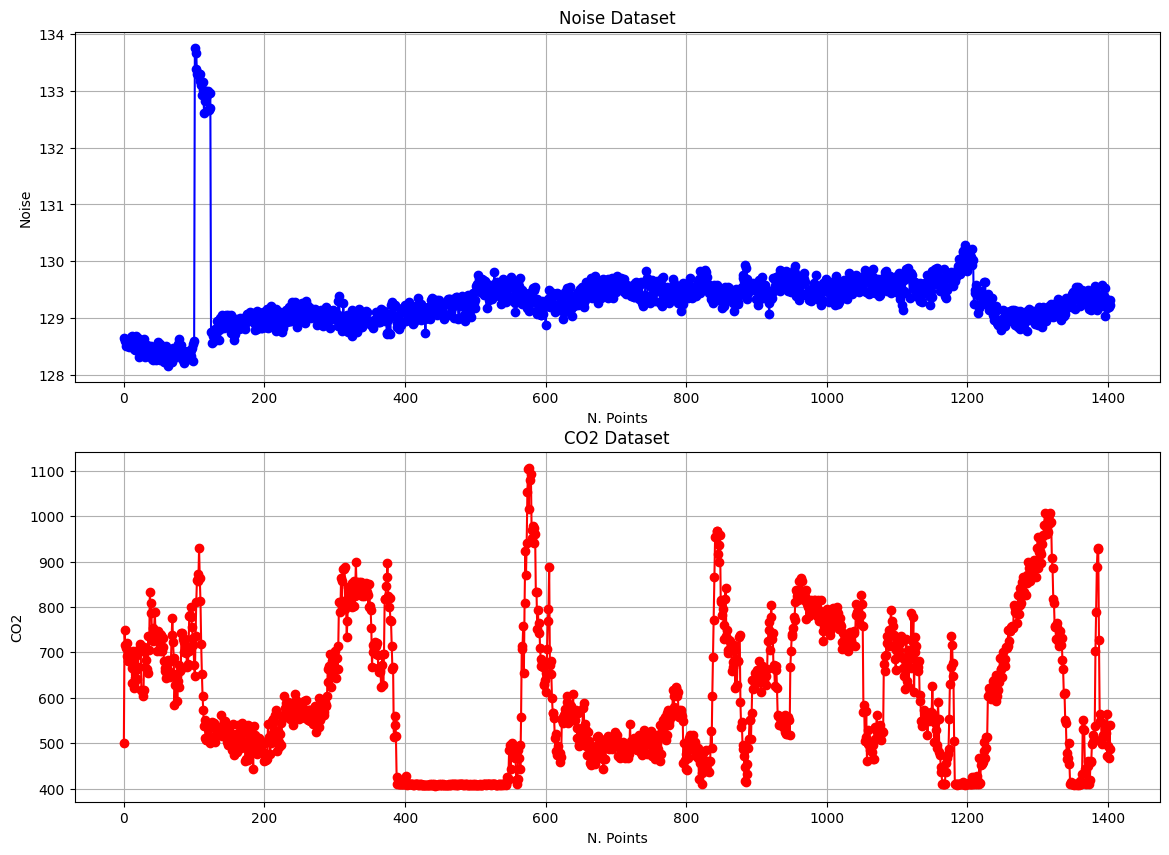

In [36]:
# Plot dataset
plt.figure(figsize=(14,10))

plt.subplot(2, 1, 1)
plt.title('Noise Dataset')
plt.plot(X, 'bo-')
plt.xlabel('N. Points')
plt.ylabel('Noise')
plt.grid()

plt.subplot(2, 1, 2)
plt.title('CO2 Dataset')
plt.plot(y, 'ro-')
plt.xlabel('N. Points')
plt.ylabel('CO2')
plt.grid()

plt.savefig('/content/dataset_2.png')
plt.show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 40, 64)            256       
                                                                 
 conv1d_14 (Conv1D)          (None, 40, 32)            4128      
                                                                 
 flatten_5 (Flatten)         (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 30)                38430     
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
Total params: 42845 (167.36 KB)
Trainable params: 42845 (167.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
82/8

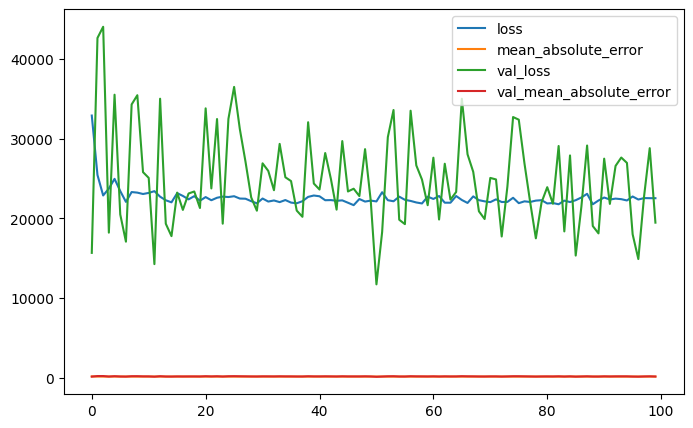

In [37]:
seq_length = 40  # Lunghezza delle sequenze
X_seq, y_seq = create_sequences(X, y, seq_length)

# NON SEPARARE IL DATASET RANDOMICAMENTE (SERIE TEMPORALI)
N = len(X_seq)

train_samples = int(0.6*N)
valid_samples = int(0.2*N)
test_samples = N - (train_samples + valid_samples)

# split and reshape input and label data
X_train, y_train = X_seq[: train_samples], y_seq[: train_samples]
X_val, y_val = X_seq[train_samples : -test_samples], y_seq[train_samples : -test_samples]
X_test, y_test = X_seq[-test_samples :], y_seq[-test_samples :]

# Aggiusta la forma dei dati per l'input nella LSTM
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# save test data for inference on raspberry pi 3
with open('X_test_2.npy', 'wb') as f1:
    np.save(f1, X_test)

with open('y_test_2.npy', 'wb') as f2:
    np.save(f2, y_test)

# Crea il modello
model_2 = Sequential()
model_2.add(Input(shape=(seq_length, 1), name='input')),
model_2.add(Conv1D(filters=64, kernel_size=3, activation='linear', padding='same'))
model_2.add(Conv1D(filters=32, kernel_size=2, activation='linear', padding='same'))
#model_2.add(Conv1D(filters=16, kernel_size=2, activation='linear', padding='same'))
model_2.add(Flatten())
#model_2.add(Dense(100, activation='linear'))
model_2.add(Dense(30, activation='linear'))
model_2.add(Dense(1, activation='linear'))

# Compila il modello
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics='mean_absolute_error')

# Summary del modello
model_2.summary()

# Addestra il modello
history = model_2.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=10)

# History plot
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(8, 5))
plt.show()

In [38]:
# Valuta il modello
loss = model_2.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss[0]}')
print(f'Mean Absolute Error on Test Data: {loss[1]}')

# Fai delle previsioni
y_pred = model_2.predict(X_test)

9/9 [==============================] - 0s 3ms/step - loss: 33444.1406 - mean_absolute_error: 154.7968
Mean Squared Error on Test Data: 33444.140625
Mean Absolute Error on Test Data: 154.7967987060547
9/9 [==============================] - 0s 3ms/step


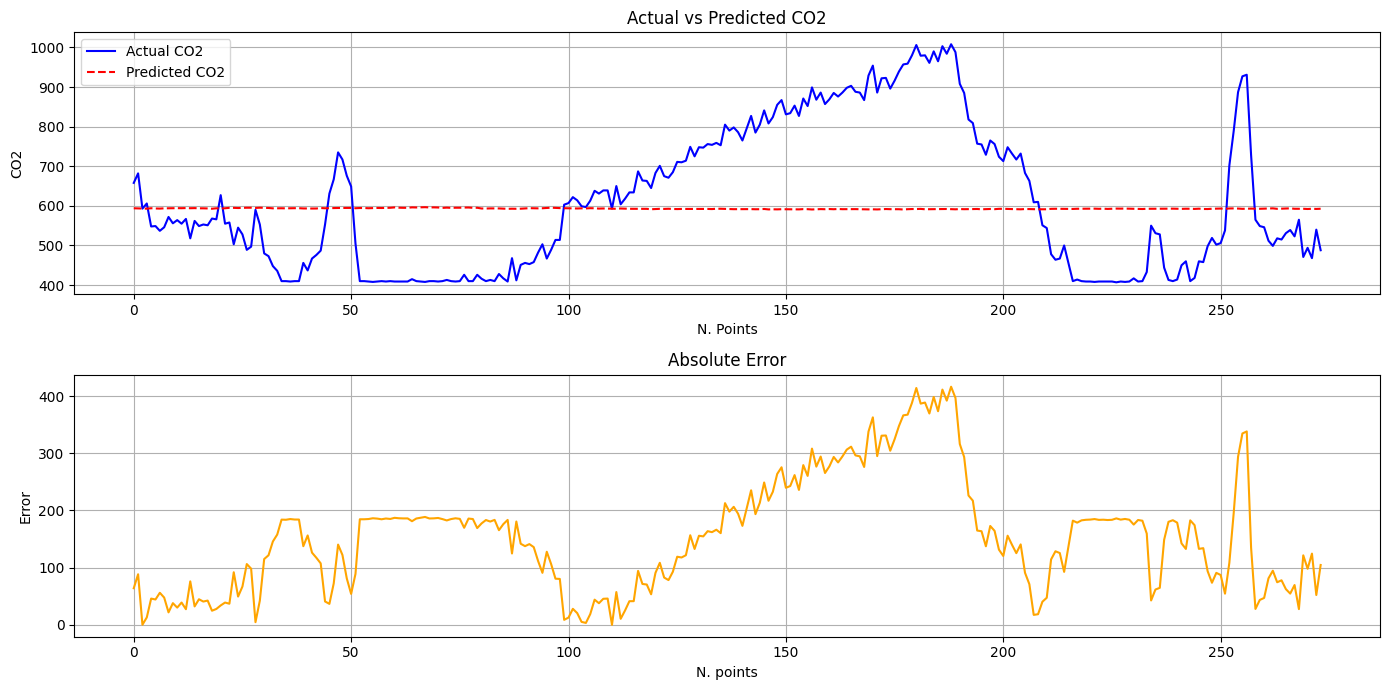

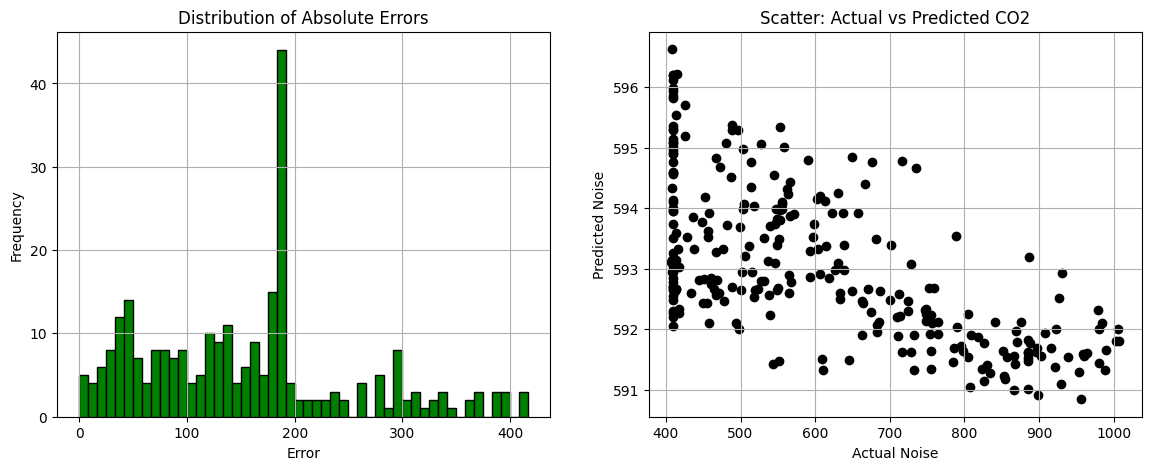

In [39]:
# Visualizza i risultati
plt.figure(figsize=(14, 7))

# Plot a linea
plt.subplot(2, 1, 1)
plt.plot(y_test, color='blue', label='Actual CO2')
plt.plot(y_pred, color='red', label='Predicted CO2', linestyle='--')
plt.title('Actual vs Predicted CO2')
plt.xlabel('N. Points')
plt.ylabel('CO2')
plt.legend()
plt.grid()

# Plot dell'errore assoluto
plt.subplot(2, 1, 2)
absolute_error = np.abs(y_test - y_pred.flatten())
plt.plot(absolute_error, color='orange')
plt.title('Absolute Error')
plt.xlabel('N. points')
plt.ylabel('Error')
plt.grid()

plt.tight_layout()
plt.savefig('/content/results_2.png')
plt.show()

# Plot della distribuzione degli errori
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(absolute_error, bins=50, color='green', edgecolor='black')
plt.title('Distribution of Absolute Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()

# Visualizza i risultati in uno scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='black')
plt.title('Scatter: Actual vs Predicted CO2')
plt.xlabel('Actual Noise')
plt.ylabel('Predicted Noise')
plt.grid()

plt.savefig('/content/distribution_2.png')
plt.show()

In [40]:
# Convert the MODEL 1
converter_1 = tf.lite.TFLiteConverter.from_keras_model(model_1)
converter_1.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model_1 = converter_1.convert()

# Save the model.
with open('model_1.tflite', 'wb') as f:
  f.write(tflite_model_1)

In [41]:
# Convert the MODEL 2
converter_2 = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter_2.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model_2 = converter_2.convert()

# Save the model.
with open('model_2.tflite', 'wb') as f:
  f.write(tflite_model_2)